In [100]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt
import sklearn.metrics as m
import time

def normalize(data):
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    return (data - data_mean) / data_std


In [101]:
file_path = r"C:\Users\advil\Desktop\579 Project\ORH.csv"
df = pd.read_csv(file_path)
selected_columns = ['tpf', 'relh', 'drct', 'sknt','slp']
new_df = df[selected_columns]

new_df = new_df.dropna()

time = df['valid']
temperature = df['tpf']
pressure = df['slp']
relative_humidity = df['relh']
wind_speed = df['sknt']
wind_dir = df['drct']

features = pd.concat([temperature, pressure, relative_humidity, wind_speed, wind_dir], axis=1)
features.index = time

features = normalize(features.values)
features = pd.DataFrame(features)

train_size = int(0.8*features.shape[0])

train_data = features.loc[0:train_size-1]
test_data = features.loc[train_size:]

#Prepare training batch
start = 120 + 1 # Use past 5 days to predict the next hour
end = start + train_size

X_train = train_data.values
y_train = features.iloc[start:end][[0]]

sequence_length = int(120)

dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    data=X_train,
    targets=y_train,
    sequence_length=sequence_length,
    sampling_rate=1
    )

x_test_end = len(test_data) - start

label_start = train_size + start

X_test = test_data.iloc[:x_test_end].values
y_test = features.iloc[label_start:][[0]]

dataset_test = keras.preprocessing.timeseries_dataset_from_array(
    X_test,
    y_test,
    sequence_length=sequence_length,
    sampling_rate=1
)

In [102]:

for batch in dataset_train.take(1):
    inputs, y_out = batch
# Define the model
Basemodel = tf.keras.Sequential([
    layers.Input(shape=(inputs.shape[1], inputs.shape[2]), name = 'input'),
    layers.LSTM(96, return_sequences=True, time_major=False),
    layers.LSTM(96),
    layers.Dense(96, activation='relu'),
    layers.Dense(1)
])

callback = tf.keras.callbacks.EarlyStopping(monitor='mae', patience=5)

# Basemodel = keras.Model(inputs=inputs, outputs=outputs)

Basemodel.compile(
    optimizer='adam', 
    loss = 'mse',
    metrics=['mae'] 
)

Basemodel.summary()


In [103]:
history = Basemodel.fit(dataset_train, validation_data= dataset_test, epochs=2000, callbacks=[callback])


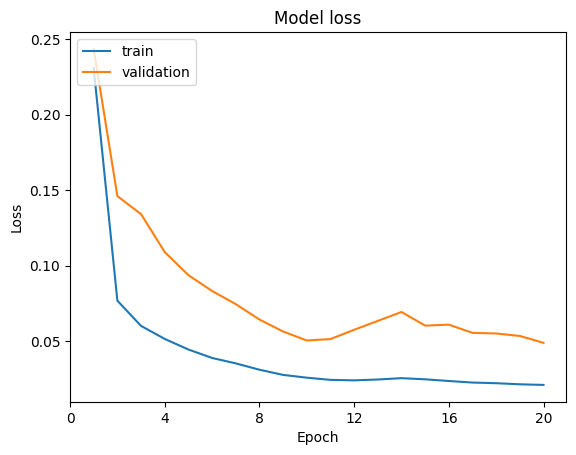

In [52]:
# "Loss"
plt.plot(range(1,21), history.history['loss'])
plt.plot(range(1,21), history.history['val_loss'])
plt.xticks(np.arange(0, 21, 4.0))
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [5]:
Basemodel.evaluate(dataset_test)

52/52 [==============================] - 2s 45ms/step - loss: 0.0489 - mae: 0.1681


[0.04890003055334091, 0.1681082546710968]

In [ ]:
import matplotlib.pyplot as plt
keras.utils.disable_interactive_logging()
temp_mean = temperature.mean(axis=0)
temp_std = temperature.std(axis=0)

time_elapsed = 0
count = 0
for x, y in dataset_test:
    start = time.time()
    prediction = Basemodel.predict(x)[0] * temp_std + temp_mean
    end =  time.time()
    count +=1
    time_elapsed += end-start

    history_data = x[0][:, 0].numpy() * temp_std + temp_mean
    true_value = y[0].numpy() * temp_std + temp_mean    
    time_steps = list(range(-(history_data.shape[0]), 0))
    plt.plot(time_steps, history_data)
    plt.plot(1, true_value, "gD")
    plt.plot(1, prediction, "rX")
    plt.legend(["Previous 120 Hours", "Recorded Hourly Temperature", "Forecasted Temperature"])
    plt.xlabel("Time (Hours)")
    plt.ylabel("Temperature (°F)")
    plt.show()
print(f"Average inference time {time_elapsed/count}")

In [ ]:
run_model = tf.function(lambda x: Basemodel(x))
# This is important, let's fix the input size.
BATCH_SIZE = 1
STEPS = 120
INPUT_SIZE = 5
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE], Basemodel.inputs[0].dtype))

Basemodel.save(r"C:\Users\advil\Desktop\579 Project\lstm_temperature_vF2", save_format= 'tf', signatures=concrete_func)

In [7]:
def representative_data_gen():
  for input_value in dataset_test.take(100):
    for model_in in tf.data.Dataset.from_tensor_slices(input_value[0]).batch(1).take(5):
      yield [np.array(model_in, dtype=np.float32, ndmin=2)]


In [94]:
# Basemodel = tf.keras.models.load_model(r"C:\Users\advil\Desktop\579 Project\lstm_temperature_vF.keras")

converter = tf.lite.TFLiteConverter.from_saved_model(r"C:\Users\advil\Desktop\579 Project\lstm_temperature_vF2")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
#converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

# Save the model.
with open(r'C:\Users\advil\Desktop\579 Project\lstm_model_vFB.tflite', 'wb') as f:
  f.write(tflite_model)

tf.lite.experimental.Analyzer.analyze(model_path=r"C:\Users\advil\Desktop\579 Project\lstm_model_vFB.tflite")

=== C:\Users\advil\Desktop\579 Project\lstm_model_vFB.tflite ===

Your TFLite model has '1' subgraph(s). In the subgraph description below,
T# represents the Tensor numbers. For example, in Subgraph#0, the UNIDIRECTIONAL_SEQUENCE_LSTM op takes
tensor #0 and tensor #8 and tensor #7 and tensor #6 and tensor #5 and tensor #16 and tensor #15 and tensor #14 and tensor #13 and tensor #-1 and tensor #-1 and tensor #-1 and tensor #12 and tensor #11 and tensor #10 and tensor #9 and tensor #-1 and tensor #-1 and tensor #21 and tensor #33 and tensor #-1 and tensor #-1 and tensor #-1 and tensor #-1 as input and produces tensor #34 as output.

Subgraph#0 main(T#0) -> [T#40]
  Op#0 UNIDIRECTIONAL_SEQUENCE_LSTM(T#0, T#8, T#7, T#6, T#5, T#16, T#15, T#14, T#13, T#-1, T#-1, T#-1, T#12, T#11, T#10, T#9, T#-1, T#-1, T#21, T#33, T#-1, T#-1, T#-1, T#-1) -> [T#34]
  Op#1 UNIDIRECTIONAL_SEQUENCE_LSTM(T#34, T#28, T#29, T#30, T#31, T#24, T#25, T#26, T#27, T#-1, T#-1, T#-1, T#20, T#19, T#18, T#17, T#-1, T#-1, T#

In [89]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=r'C:\Users\advil\Desktop\579 Project\lstm_model_vF2.tflite')
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']
# print(input_shape)
input_tflite = []
output_tflite = []
for x, y in dataset_test:
    input_tflite.append(x)
    output_tflite.append(y)

temp_mean = temperature.mean(axis=0)
temp_std = temperature.std(axis=0)

output_pred = []
true_y = []
for i in range(len(input_tflite)):
    input_data = tf.cast(input_tflite[i],tf.float32)
    length = input_data.get_shape().as_list()
    for j in range(length[0]):
        #Conduct and measure inference
        interpreter.set_tensor(input_details[0]['index'], [input_data[j]])
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        end = time.time()
        #Post Inference Processing
        prediction = output_data #* temp_std + temp_mean
        output_pred.append(prediction[0][0])
        true_y.append(output_tflite[i][j].numpy()[0])
        
        # history_data = input_tflite[i][0][:, 1].numpy() * temp_std + temp_mean
        # true_value = output_tflite[i][0].numpy() #* temp_std + temp_mean



    # time_steps = list(range(-(history_data.shape[0]), 0))
    # plt.plot(time_steps, history_data)
    # plt.plot(1, true_value, "gD")
    # plt.plot(1, prediction, "rX")
    # plt.legend(["Previous 120 Hours", "Recorded Hourly Temperature", "Forecasted Temperature"])
    # plt.xlabel("Time")
    # plt.show()
    # print(f"Model Output is: {output_data[0]}")
    # print(f"Expected Output is: \n{output_tflite[0][1]}")

In [80]:
print(f"MAE is: {m.mean_absolute_error(true_y, output_pred)}")
print(f"Val loss is: {m.mean_squared_error(true_y, output_pred)}")

MAE is: 0.17036550830862202
Val loss is: 0.05015637640882792


Transfer TFLite Model to C Array for Arduino Nano Implementation

In [9]:
def hex_to_c_array(hex_data, var_name):

  c_str = ''

  # Create header guard
  c_str += '#ifndef ' + var_name.upper() + '_H\n'
  c_str += '#define ' + var_name.upper() + '_H\n\n'

  # Add array length at top of file
  c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
  c_str += 'unsigned char ' + var_name + '[] = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
  c_str += '#endif //' + var_name.upper() + '_H'

  return c_str

In [10]:
with open(r'C:\Users\advil\Desktop\579 Project\lstm_vF2_h.h', 'w') as file:
  file.write(hex_to_c_array(tflite_model, 'lstm_vF2_h'))